# Assignment 4

### <span style="color:chocolate"> Submission requirements </span>

Your work will not be graded if your notebook doesn't include output. In other words, <span style="color:red"> make sure to rerun your notebook before submitting to Gradescope </span> (Note: if you are using Google Colab: go to Edit > Notebook Settings  and uncheck Omit code cell output when saving this notebook, otherwise the output is not printed).

Additional points may be deducted if these requirements are not met:
    
* Comment your code;
* Each graph should have a title, labels for each axis, and (if needed) a legend. Each graph should be understandable on its own;
* Try and minimize the use of the global namespace (meaning, keep things inside functions).
---

### Import libraries

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns  # for nicer plots
sns.set(style="darkgrid")  # default style

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow import keras
from keras import metrics
from keras.datasets import fashion_mnist

tf.get_logger().setLevel('INFO')

2024-06-09 15:41:25.901341: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-09 15:41:25.908754: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-09 15:41:26.123747: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-09 15:41:26.923067: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-09 15:41:29.465157: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warnin

---
### Step 1: Data ingestion

You'll train a binary classifier using the [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset. This consists of 70,000 grayscale images (28x28). Each image is associated with 1 of 10 classes. The dataset was split by the creators; there are 60,000 training images and 10,000 test images. Note also that Tensorflow includes a growing [library of datasets](https://www.tensorflow.org/datasets/catalog/overview) and makes it easy to load them in numpy arrays.

In [2]:
# Load the Fashion MNIST dataset.
(X_train, Y_train), (X_test, Y_test) = fashion_mnist.load_data()

---
### Step 2: Exploratory Data Analysis (EDA)

Exploratory Data Analysis (EDA) and Data Preprocessing are often iterative processes that involve going back and forth to refine and improve the quality of data analysis and preparation. However, the specific order can vary depending on the project's requirements. In some cases, starting with EDA, as you see in this assignment, could be more useful, but there is no rigid rule dictating the sequence in all situations.

### <span style="color:chocolate">Exercise 1:</span> Getting to know your data (5 points)

Complete the following tasks:

1. Print the shapes and types of (X_train, Y_train) and (X_test, Y_test). Interpret the shapes (i.e., what do the numbers represent?). Hint: For types use the <span style="color:chocolate">type()</span> function.
2. Define a list of strings of class names corresponding to each class in (Y_train, Y_test). Call this list label_names. Hint: Refer to the Fashion MNIST documentation.

In [3]:
print('X_train type:', type(X_train), '; shape:', X_train.shape)
print('Y_train type:', type(Y_train), '; shape:', Y_train.shape)
print('X_test type:', type(X_test), '; shape:', X_test.shape)
print('Y_test type:', type(Y_test), '; shape:', Y_test.shape)

msg = '''\nThe first number of the shape is the number of samples, so
there are 60,000 samples in the train sets and 10,000 in the test sets.
For the X sets, the next two numbers represent the 28x28 image data,
meaning for each of the 28 rows, there are 28 columns of data.'''
print(msg)

# Create list of the label names, per https://keras.io/api/datasets/fashion_mnist/
label_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 
               'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

X_train type: <class 'numpy.ndarray'> ; shape: (60000, 28, 28)
Y_train type: <class 'numpy.ndarray'> ; shape: (60000,)
X_test type: <class 'numpy.ndarray'> ; shape: (10000, 28, 28)
Y_test type: <class 'numpy.ndarray'> ; shape: (10000,)

The first number of the shape is the number of samples, so
there are 60,000 samples in the train sets and 10,000 in the test sets.
For the X sets, the next two numbers represent the 28x28 image data,
meaning for each of the 28 rows, there are 28 columns of data.


### <span style="color:chocolate">Exercise 2:</span> Getting to know your data - cont'd (5 points)

Fashion MNIST images have one of 10 possible labels (shown above). 

Complete the following tasks:

1. Display the first 5 images in X_train for each class in Y_train, arranged in a 10x5 grid. Use the label_names list defined above;
2. Determine the minimum and maximum pixel values for images in the X_train dataset.

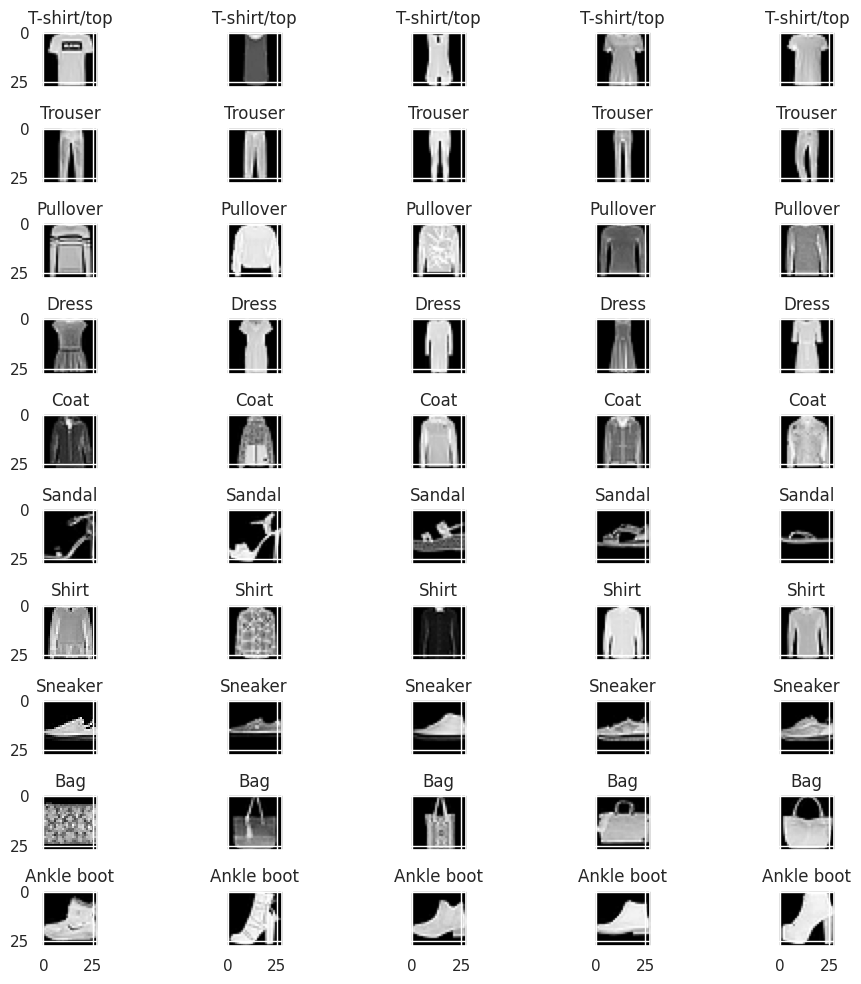

Min pixel values for X_train =  0
Max pixel values for X_train =  255


In [4]:
# create 10x5 grid of the first 5 images for each class
fig, ax = plt.subplots(10,5, sharex=True, sharey=True, figsize=(10,10))

# Loop thru label names
for i in range(len(label_names)):
    # get the first 5 examples
    class_idx = np.where(Y_train == i)[0][:5]
    # loop through first 5 examples
    for j in range(len(class_idx)):
        curr_img = X_train[class_idx[j]]
        ax[i][j].imshow(curr_img, cmap='gray')
        ax[i][j].set_title(label_names[i])

plt.tight_layout()
plt.show()

print('Min pixel values for X_train = ', X_train.min())
print('Max pixel values for X_train = ', X_train.max())


---
### Step 3: Data preprocessing

This step is essential for preparing this image data in a format that is suitable for ML algorithms. 

### <span style="color:chocolate">Exercise 3:</span> Feature preprocessing (5 points)

In the previous lab, the input data had just a few features. Here, we treat **every pixel value as a separate feature**, so each input example has 28x28 (784) features!

In this exercise, you'll perform the following tasks:

1. Normalize the pixel values in both X_train and X_test data so they range between 0 and 1;
2. For each image in X_train and X_test, flatten the 2-D 28x28 pixel array to a 1-D array of size 784. Hint: use the <span style="color:chocolate">reshape()</span> method available in NumPy. Note that by doing so you will overwrite the original arrays;
3. Pint the shape of X_train and X_test arrays.

In [5]:
# Normalize data; use min and max from train set
X_train_max = X_train.max()
X_train_min = X_train.min()

X_train = (X_train - X_train_min) / (X_train_max - X_train_min)
X_test = (X_test - X_train_min) / (X_train_max - X_train_min)

# flatten the 28x28 arrays to 1-d of 784
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1] * X_train.shape[2]))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1] * X_test.shape[2]))

print('X_train shape = ', X_train.shape)
print('X_test shape = ', X_test.shape)


X_train shape =  (60000, 784)
X_test shape =  (10000, 784)


### <span style="color:chocolate">Exercise 4:</span> Label preprocessing (5 points)

This assignment involves binary classification. Specifically, the objective is to predict whether an image belongs to the sneaker class (class 7) or not.

Therefore, write code so that for each example in (Y_train, Y_test), the outcome variable is represented as follows: 
* $y=1$, for sneaker class (positive examples), and
* $y=0$, for non-sneaker class (negative examples).

Note: To avoid "ValueError: assignment destination is read-only", first create a copy of the (Y_train, Y_test) data and call the resulting arrays (Y_train, Y_test). Then overwrite the (Y_train, Y_test) arrays to create binary outcomes.

In [6]:
# Make copies of the original dataset for binary classification task.
Y_train = np.copy(Y_train)
Y_test = np.copy(Y_test)

Y_train = np.where(Y_train == 7, 1, 0)
Y_test = np.where(Y_test == 7, 1, 0)


### <span style="color:chocolate">Exercise 5:</span> Data splits (10 points)

Using the <span style="color:chocolate">train_test_split()</span> method available in scikit-learn:
1. Retain 20% from the training data for validation purposes. Set random state to 1234. Name the resulting dataframes as follows: X_train_mini, X_val, Y_train_mini, Y_val.
2. Print the shape of each array.

In [7]:
X_train_mini, X_val, Y_train_mini, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=1234) 

print('Shape of X_train_mini =', X_train_mini.shape)
print('Shape of X_val =', X_val.shape)
print('Shape of Y_train_mini =', Y_train_mini.shape)
print('Shape of Y_val =', Y_val.shape)


Shape of X_train_mini = (48000, 784)
Shape of X_val = (12000, 784)
Shape of Y_train_mini = (48000,)
Shape of Y_val = (12000,)


### <span style="color:chocolate">Exercise 6:</span> Data shuffling (10 points)

Since you'll be using Batch Gradient Descent (BGD) for training, it is important that **each batch is a random sample of the data** so that the gradient computed is representative. 

1. Use [integer array indexing](https://numpy.org/doc/stable/reference/arrays.indexing.html#integer-array-indexing) to re-order (X_train_mini, Y_train_mini) using a list of shuffled indices. In doing so, you will overwrite the arrays.

In [8]:
np.random.seed(0)
shuffled_indices = np.random.permutation(range(len(Y_train_mini)))

X_train_mini = X_train_mini[shuffled_indices]
Y_train_mini = Y_train_mini[shuffled_indices]

---
### Step 4: Exploratory Data Analysis (EDA) - cont'd

Before delving into model training, let's further explore the raw feature values by comparing sneaker and non-sneaker training images.

### <span style="color:chocolate">Exercise 7:</span> Pixel distributions (10 points)

1. Identify all sneaker images in X_train_mini and calculate the mean pixel value for each sneaker image. Visualize these pixel values using a histogram. Print the mean pixel value across all sneaker images.
2. Identify all non-sneaker images in X_train_mini and calculate the mean pixel value for each non-sneaker image. Visualize these pixel values using a histogram. Print the mean pixel value across all non-sneaker images.
3. Based on the histogram results, assess whether there is any evidence suggesting that pixel values can be utilized to distinguish between sneaker and non-sneaker images. Justify your response.

Notes: Make sure to provide a descriptive title and axis labels for each histogran. Make sure you utilize Y_train_mini to locate the sneaker and non-sneaker class.

Mean pixel value across all sneaker images =  0.168
Mean pixel value across all non-sneaker images =  0.299


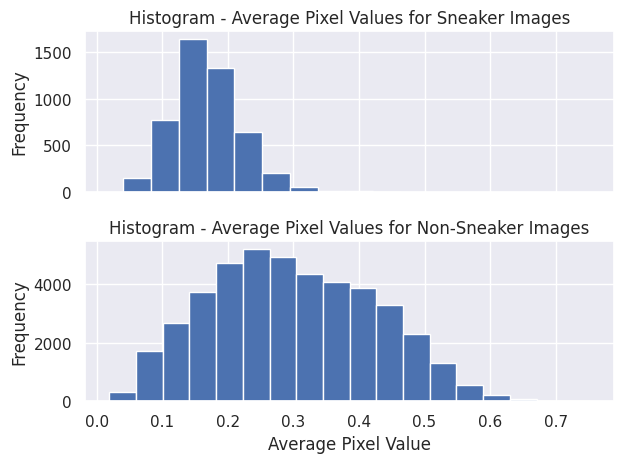


The distribution of the average pixel value for the sneaker images is highest
between 0.1 and 0.2, while the average for the non-sneaker images is highest
closer to 0.3. Additionally, the averages for the sneaker images have a 
smaller variance than the non-sneaker images. This gives us reason to believe 
that the pixel values should contain enough information to distinguish between 
those 2 classes.



In [9]:
# get indexes for the sneaker images
sneaker_idx = np.where(Y_train_mini == 1)[0]

# get average pixel value for each sneaker sample
sneaker_pixel_averages = [s.mean() for s in X_train_mini[sneaker_idx]]
print(f'Mean pixel value across all sneaker images = {X_train_mini[sneaker_idx].mean(): 0.3f}')

# create plots of the histogram for averages; share X-axis to better
# visualize differences
fig, ax = plt.subplots(2, sharex=True)

# plot histogram of averages
ax[0].hist(sneaker_pixel_averages)
ax[0].set_title('Histogram - Average Pixel Values for Sneaker Images')
ax[0].set_ylabel('Frequency')

# get indexes for the non-sneaker images
non_sneaker_idx = np.where(Y_train_mini == 0)[0]

# get average pixel value for each non-sneaker sample
non_sneaker_pixel_averages = [s.mean() for s in X_train_mini[non_sneaker_idx]]
print(f'Mean pixel value across all non-sneaker images = {X_train_mini[non_sneaker_idx].mean(): 0.3f}')

# plot histogram of averages
ax[1].hist(non_sneaker_pixel_averages, bins=18)
ax[1].set_title('Histogram - Average Pixel Values for Non-Sneaker Images')
ax[1].set_xlabel('Average Pixel Value')
ax[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

msg = """
The distribution of the average pixel value for the sneaker images is highest
between 0.1 and 0.2, while the average for the non-sneaker images is highest
closer to 0.3. Additionally, the averages for the sneaker images have a 
smaller variance than the non-sneaker images. This gives us reason to believe 
that the pixel values should contain enough information to distinguish between 
those 2 classes.
"""
print(msg)

---
### Step 4: Modeling

### <span style="color:chocolate">Exercise 8:</span> Baseline model (10 points)

When dealing with classification problems, a simple baseline is to select the *majority* class (the most common label in the training set) and use it as the prediction for all inputs.

With this information in mind:

1. What is the number of sneaker images in Y_train_mini?
2. What is the number of non-sneaker images in Y_train_mini?
3. What is the majority class in Y_train_mini?
4. What is the accuracy of a majority class classifier for Y_train_mini?
5. Implement a function that computes the Log Loss (binary cross-entropy) metric and use it to evaluate this baseline on both the mini train (Y_train_mini) and validation (Y_val) data. Use 0.1 as the predicted probability for your baseline (reflecting what we know about the original distribution of classes in the mini training data). Hint: for additional help, see the file ``04 Logistic Regression with Tensorflow_helpers.ipynb``.

In [10]:
# get the counts of the 2 classes
num_sneakers = Y_train_mini.sum()
num_nonsneakers = np.count_nonzero(Y_train_mini==0)

print(f'Number of sneaker images in Y_train_mini = {num_sneakers:,}')
print(f'Number of non-sneaker images in Y_train_mini = {num_nonsneakers:,}')
print('The majority class in Y_train_mini is "non-sneaker"')
print(f'The accuracy of the majority class classifer = {num_nonsneakers / len(Y_train_mini) * 100: 0.2f}%')

# define a function for log loss
def log_loss(Y, Y_hat):
    """Calculate the log loss (binary cross-entropy) for a given Y

    ARGS
    ------------
    Y: np.array of m examples with actual values
    Y_hat: np.array of m examples with predicted values

    RETURNS
    ------------
    float: the log loss
    """
    m = Y.shape[0]
    
    return np.sum(-Y * np.log(Y_hat) - (1 - Y) * np.log(1 - Y_hat)) / m

# Create predictions using majority class; baseline prob = 0.1
Y_train_mini_preds_baseline = np.array([0.1 for x in Y_train_mini])
Y_val_preds_baseline = np.array([0.1 for x in Y_val])

# get the log loss for the baseline predictions
Y_train_mini_baseline_logloss = log_loss(Y_train_mini, Y_train_mini_preds_baseline)
Y_val_baseline_logloss = log_loss(Y_val, Y_val_preds_baseline)

print(f'Log Loss for Y_train_mini = {Y_train_mini_baseline_logloss: .4f}')
print(f'Log Loss for Y_val = {Y_val_baseline_logloss: .4f}')


Number of sneaker images in Y_train_mini = 4,800
Number of non-sneaker images in Y_train_mini = 43,200
The majority class in Y_train_mini is "non-sneaker"
The accuracy of the majority class classifer =  90.00%
Log Loss for Y_train_mini =  0.3251
Log Loss for Y_val =  0.3251


### <span style="color:chocolate">Exercise 9:</span> Improvement over Baseline with TensorFlow (10 points)

Let's use TensorFlow to train a binary logistic regression model much like you did in the previous assignment. The goal here is to build a ML model to improve over the baseline classifier.

1. Fill in the <span style="color:green">NotImplemented</span> parts of the build_model() function below by following the instructions provided as comments. Hint: the activation function, the loss, and the evaluation metric are different compared to the linear regression model;
2. Build and compile a model using the build_model() function and the (X_train_mini, Y_train_mini) data. Set learning_rate = 0.0001. Call the resulting object *model_tf*.
3. Train *model_tf* using the (X_train_mini, Y_train_mini) data. Set num_epochs = 5 and batch_size=32. Pass the (X_val, Y_val) data for validation. Hint: see the documentation behind the [tf.keras.Model.fit()](https://bcourses.berkeley.edu/courses/1534588/files/88733489?module_item_id=17073646) method.
3. Generate a plot (for the mini training and validation data) with the loss values on the y-axis and the epoch number on the x-axis for visualization. Make sure to include axes name and title. Hint: check what the [tf.keras.Model.fit()](https://bcourses.berkeley.edu/courses/1534588/files/88733489?module_item_id=17073646) method returns.

In [11]:
def build_model(num_features, learning_rate):
  """Build a TF linear regression model using Keras.

  Args:
    num_features: The number of input features.
    learning_rate: The desired learning rate for SGD.

  Returns:
    model: A tf.keras model (graph).
  """
  # This is not strictly necessary, but each time you build a model, TF adds
  # new nodes (rather than overwriting), so the colab session can end up
  # storing lots of copies of the graph when you only care about the most
  # recent. Also, as there is some randomness built into training with SGD,
  # setting a random seed ensures that results are the same on each identical
  # training run.
  tf.keras.backend.clear_session()
  tf.random.set_seed(0)

  # Build a model using keras.Sequential. While this is intended for neural
  # networks (which may have multiple layers), we want just a single layer for
  # binary logistic regression.
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Dense(
      units=1,        # output dim
      input_shape=(num_features,),  # input dim
      use_bias=True,               # use a bias (intercept) param
      activation='sigmoid',
      kernel_initializer=tf.ones_initializer,  # initialize params to 1
      bias_initializer=tf.ones_initializer,    # initialize bias to 1
  ))

  # We need to choose an optimizer. We'll use SGD, which is actually mini-batch SGD
  optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)

  # Finally, compile the model. Select the accuracy metric. This finalizes the graph for training.
  model.compile(
      loss=tf.keras.losses.BinaryCrossentropy(), 
      optimizer=optimizer,
      metrics=[tf.keras.metrics.BinaryAccuracy()]
    )
    
  return model

/home/jcisneros/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - binary_accuracy: 0.1017 - loss: 208.5961 - val_binary_accuracy: 0.1000 - val_loss: 199.9825
Epoch 2/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - binary_accuracy: 0.1017 - loss: 196.0804 - val_binary_accuracy: 0.1000 - val_loss: 187.4252
Epoch 3/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - binary_accuracy: 0.1017 - loss: 183.5648 - val_binary_accuracy: 0.1000 - val_loss: 174.8680
Epoch 4/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - binary_accuracy: 0.1017 - loss: 171.0492 - val_binary_accuracy: 0.1000 - val_loss: 162.3107
Epoch 5/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - binary_accuracy: 0.1017 - loss: 158.5334 - val_binary_accuracy: 0.1000 - val_loss: 149.7533


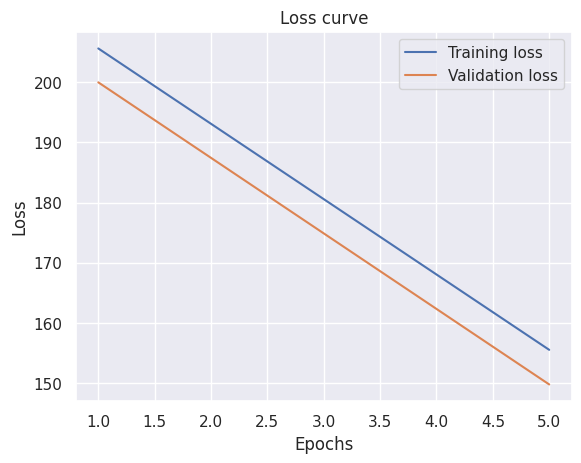

In [12]:
tf.random.set_seed(0)
# 2. Build and compile model
learning_rate = 0.0001
epochs = 5
batch_size = 32

model_tf = build_model(num_features=X_train_mini.shape[1], learning_rate=learning_rate)

# 3. Fit the model
model_fit = model_tf.fit(
    x=X_train_mini,
    y=Y_train_mini,
    epochs=epochs,
    validation_data=(X_val, Y_val)
)

# Plot the loss
train_loss = model_fit.history['loss']
val_loss = model_fit.history['val_loss']
epochs_axis = range(1, epochs+1)
plt.plot(epochs_axis, train_loss, label='Training loss')
plt.plot(epochs_axis, val_loss, label='Validation loss')
plt.title('Loss curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.show()

---
### Step 5: Hyperparameter tuning

Hyperparameter tuning is a crucial step in optimizing ML models. It involves systematically adjusting hyperparameters such as learning rate, number of epochs, and optimizer to find the model configuration that leads to the best generalization performance.

This tuning process is typically conducted by monitoring the model's performance on the validation vs. training set. It's important to note that using the test set for hyperparameter tuning can compromise the integrity of the evaluation process by violating the assumption of "blindness" of the test data.

### <span style="color:chocolate">Exercise 10:</span> Hyperparameter tuning (10 points)

1. Fine-tune the hyperparameters of *model_tf* to determine the setup that yields the most optimal performance. Feel free to explore various values for the hyperparameters. Hint: ask your instructors and TAs for help if in doubt.

After identifying your preferred model configuration, print the following information:

2. The first five learned parameters of the model (this should include the bias term);
3. The loss at the final epoch on both the mini training and validation datasets;
4. The percentage difference between the losses observed on the mini training and validation datasets.
5. Compare the training/validation loss of the TensorFlow model (model_tf) with the baseline model's loss. Does the TensorFlow model demonstrate an improvement over the baseline model?


Please note that we will consider 'optimal model configuration' any last-epoch loss that is below 0.08.

First 5 model parameters:
	Non-bias parameters: [[0.9998151 ]
 [0.99942183]
 [0.9958999 ]
 [0.9879104 ]]
	Bias parameter: [-2.2606864]
Final loss amount for training: 0.0693
Final loss amount for validation: 0.0670
Percent difference in traning and validation losses: -3.33%

The logistic model is a significant improvement over the baseline
model. The losses for the baseline model on the train and validation
set were both .3251, and for the new model the losses are 0.0693
and 0.0670, resepctively.



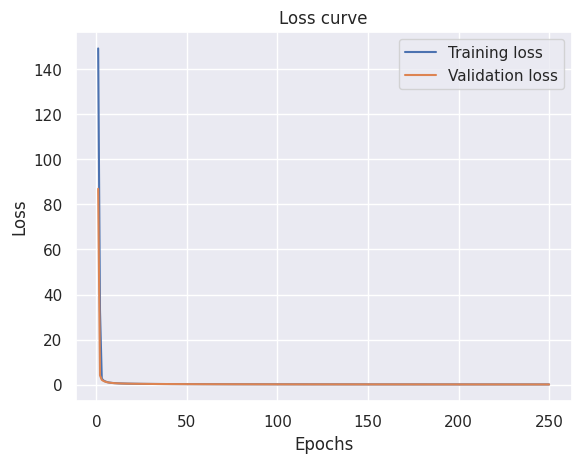

In [13]:
tf.random.set_seed(0)
# Build and compile model
learning_rate = 0.001
epochs = 250

model_tf = build_model(num_features=X_train_mini.shape[1], learning_rate=learning_rate)

# Fit the model
model_fit = model_tf.fit(
    x=X_train_mini,
    y=Y_train_mini,
    epochs=epochs,
    validation_data=(X_val, Y_val),
    verbose=0
)

# Print model configuration
train_final_loss = model_fit.history['loss'][epochs-1]
val_final_loss = model_fit.history['val_loss'][epochs-1]
print('First 5 model parameters:')
print('\tNon-bias parameters:', model_tf.layers[0].get_weights()[0][:4])
print('\tBias parameter:', model_tf.layers[0].get_weights()[1])
print(f'Final loss amount for training: {train_final_loss:.4f}')
print(f'Final loss amount for validation: {val_final_loss:.4f}')
print(f'Percent difference in traning and validation losses: {(val_final_loss - train_final_loss) / train_final_loss * 100:.2f}%')

# Answer for compare against baseline
msg = f"""
The logistic model is a significant improvement over the baseline
model. The losses for the baseline model on the train and validation
set were both .3251, and for the new model the losses are {train_final_loss:.4f}
and {val_final_loss:.4f}, resepctively.
"""
print(msg)

# Plot the loss
train_loss = model_fit.history['loss']
val_loss = model_fit.history['val_loss']
epochs_axis = range(1, epochs+1)

plt.plot(epochs_axis, train_loss, label='Training loss')
plt.plot(epochs_axis, val_loss, label='Validation loss')
plt.title('Loss curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.show()

---
### Step 6: Evaluation and Generalization


Now that you've determined the optimal set of hyperparameters, it's time to evaluate your optimized model on the test data to gauge its performance in real-world scenarios, commonly known as inference.

### <span style="color:chocolate">Exercise 11:</span> Computing accuracy (10 points)

1. Calculate aggregate accuracy on both mini train and test datasets using a probability threshold of 0.5. Hint: You can utilize the <span style="color:chocolate">model.evaluate()</span> method provided by tf.keras. Note: Aggregate accuracy measures the overall correctness of the model across all classes in the dataset;

2. Does the model demonstrate strong aggregate generalization capabilities? Provide an explanation based on your accuracy observations.

In [14]:
# evaluate model on train and test data sets
train_mini_eval = model_tf.evaluate(
    x=X_train_mini,
    y=Y_train_mini,
    verbose=0
)

test_eval = model_tf.evaluate(
    x=X_test,
    y=Y_test,
    verbose=0
)

print('1. Accuracy')
print(f'Accuracy for train data: {train_mini_eval[1]*100:.2f}%')
print(f'Accuracy for test data: {test_eval[1]*100:.2f}%')

print('-'*50)
print(f'''2. Generalization Capabilities:
This model does a good job generalizing the aggrgrate capabilities.
The accuracy for the validation set is 97.46% compared to the training
set with an accuracy of 97.65%.
''')


1. Accuracy
Accuracy for train data: 97.65%
Accuracy for test data: 97.46%
--------------------------------------------------
2. Generalization Capabilities:
This model does a good job generalizing the aggrgrate capabilities.
The accuracy for the validation set is 97.46% compared to the training
set with an accuracy of 97.65%.



### <span style="color:chocolate">Exercise 12:</span> Fairness evaluation (10 points)

1. Generate and visualize the confusion matrix on the test dataset using a probability threshold of 0.5. Additionally, print the True Positives (TP), False Negatives (FN), False Positives (FP), and True Negatives (TN). Hint: you can utilize the <span style="color:chocolate">model.predict()</span> method available in tf.keras, and then the <span style="color:chocolate">confusion_matrix()</span>, <span style="color:chocolate">ConfusionMatrixDisplay()</span> methods available in sklearn.metrics;

2. Compute subgroup accuracy, separately for the sneaker and non-sneaker classes, on the test dataset using a probability threshold of 0.5. Reflect on any observed accuracy differences (potential lack of fairness) between the two classes.

3. Does the model demonstrate strong subgroup generalization capabilities? Provide an explanation based on your accuracy observations.

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


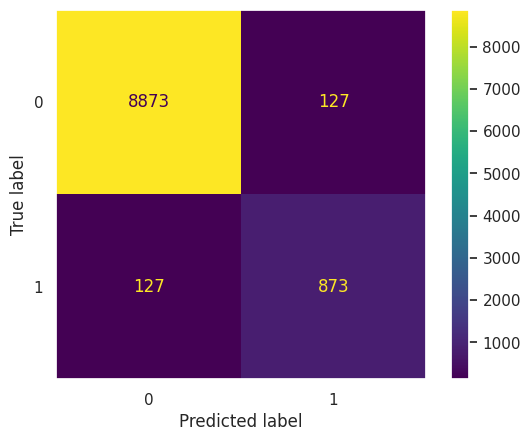

True Positives = 873
False Negatives = 127
False Positives = 127
True Negatives = 8873
Accuracy for sneakers =  87.30%
Accuracy for non-sneakers =  98.59%

The accuracy for the non-sneakers is higher than sneakers. This can be 
attributed to the fact that 90% of the examples are non-sneakers. That means
the model has 9 times the examples to identify the non-sneaker class than
examples for the sneaker class. The model will get much better at the 
non-sneaker class during training because of the outsized weight.


The model has strong subgroup generalization capabilities compared to our 
baseline. In our baseline model we would not guess any of the sneakers and
our non-sneaker guesses would be right 90% of the time. We are now
87% accurate for identifying sneaker and almost 99% on non-sneakers.



In [15]:
# get the predicted values for Test
Y_test_pred = model_tf.predict(x=X_test).flatten()

# convert the probabilities to the 0, 1 class values
Y_test_pred = np.where(Y_test_pred >= 0.5, 1, 0)

# print confusion matrix
labels = ('non-sneaker', 'sneaker')
cm = confusion_matrix(Y_test, Y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.grid(False)
plt.show()

print(f'True Positives = {cm[1][1]}')
print(f'False Negatives = {cm[1][0]}')
print(f'False Positives = {cm[0][1]}')
print(f'True Negatives = {cm[0][0]}')

print(f'Accuracy for sneakers = {cm[1][1] / (cm[1][0] + cm[1][1]) * 100: .2f}%')
print(f'Accuracy for non-sneakers = {cm[0][0] / (cm[0][0] + cm[0][1]) * 100: .2f}%')

msg = """
The accuracy for the non-sneakers is higher than sneakers. This can be 
attributed to the fact that 90% of the examples are non-sneakers. That means
the model has 9 times the examples to identify the non-sneaker class than
examples for the sneaker class. The model will get much better at the 
non-sneaker class during training because of the outsized weight.
"""
print(msg)

msg = """
The model has strong subgroup generalization capabilities compared to our 
baseline. In our baseline model we would not guess any of the sneakers and
our non-sneaker guesses would be right 90% of the time. We are now
87% accurate for identifying sneaker and almost 99% on non-sneakers.
"""
print(msg)

----
### <span style="color:chocolate">Bonus question</span> (20 points)

Is it possible to enhance the prediction accuracy for the sneaker class by performing the following steps?

1. Implement data balancing techniques, such as oversampling or undersampling, to equalize the representation of both classes.
2. After balancing the data, retrain the model on the balanced dataset.
3. Evaluate the model's performance, particularly focusing on the accuracy achieved for the sneaker class.

Note: provide a separate notebook for the Bonus exercise. Name it ``04 Logistic Regression with Tensorflow_bonus``.